In [1]:
import os
import sys
#sys.path.insert(1, '../Src/')
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

PATH_DATA = '../../Data/'

np.random.seed(42)

%matplotlib inline

In [2]:
fname = "stringer_spontaneous.npy"
fname =os.path.join(PATH_DATA,fname)

In [3]:
# @title Data loading
dat = np.load(fname, allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# neural activity vs run

In [4]:
dat['sresp'].shape

(11983, 7018)

In [5]:
X = dat['sresp'].T
X.shape

(7018, 11983)

In [6]:
X[0]

array([ 2.9820833,  5.001608 ,  7.6890087, ..., 91.94794  ,  0.       ,
        1.1490179], dtype=float32)

In [7]:
y = dat['run']

In [8]:
y[0]

array([0.04362508])

# remove outliers

In [9]:
total_sresp = X.flatten()
for percentile in [25,50,75,90,100]:
    print('percentile '+str(percentile)+': ',np.percentile(total_sresp, percentile))

percentile 25:  0.0
percentile 50:  15.809068202972412
percentile 75:  48.536081314086914
percentile 90:  96.9262748718262
percentile 100:  2417.7021484375


In [10]:
threshold = np.percentile(total_sresp, 95)
print('threshold :',threshold)

threshold : 143.89718170165997


In [11]:
threshold = 1000

In [12]:
X.shape

(7018, 11983)

In [13]:
columns_id = []
outliers_columns_id = []

for i in range(X.shape[1]):
    values = X[:,i]
    if np.sum(values>threshold)==0:
        columns_id.append(i)
    else:
        outliers_columns_id.append(i)

In [14]:
np.sum(X[:,100]>threshold)

0

In [15]:
len(columns_id)

8277

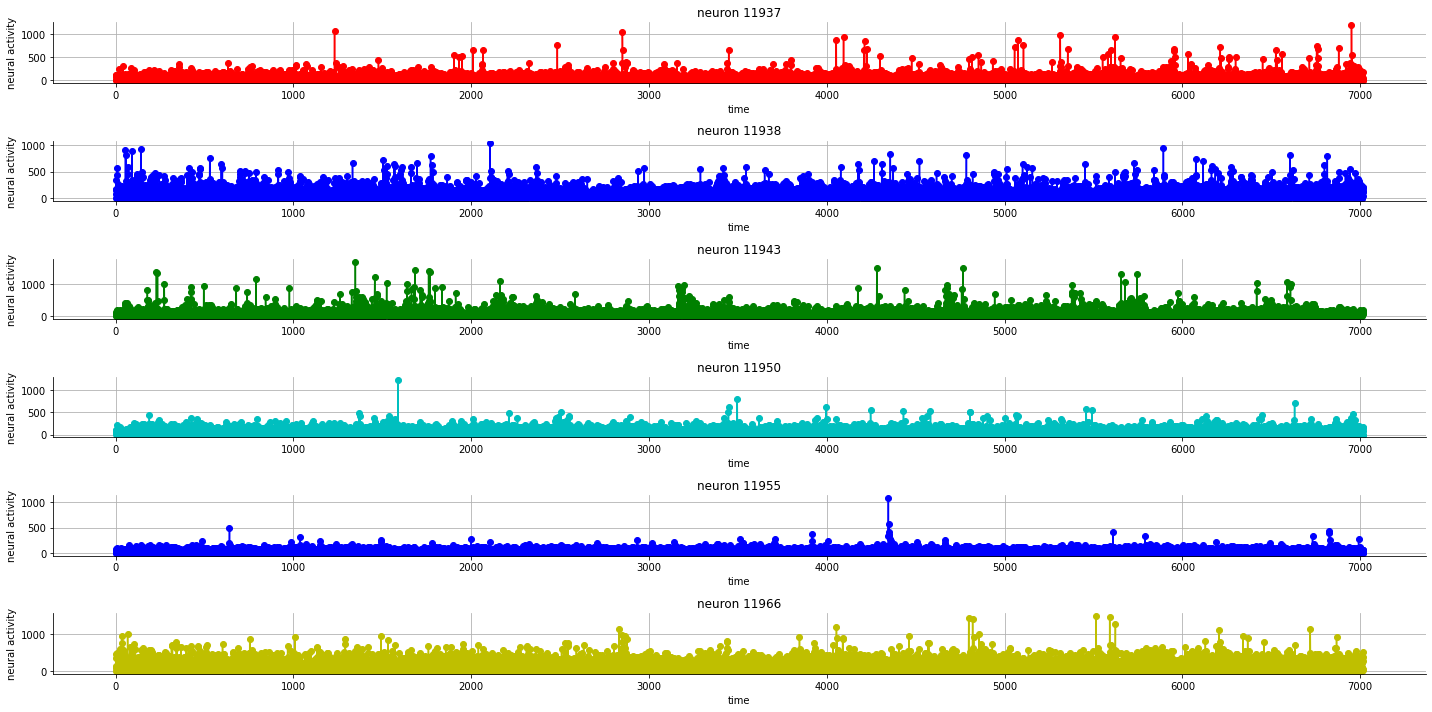

In [16]:
fig, axs = plt.subplots(6, 1,figsize=(20,10))
cnt = 0
for idx,color in zip(outliers_columns_id[-6:],['r','b','g','c','b','y']):
    axs[cnt].plot(X[:,idx],'-'+color+'o')
    axs[cnt].set_xlabel('time')
    axs[cnt].set_ylabel('neural activity')
    axs[cnt].set_title('neuron '+str(idx))
    axs[cnt].grid(True)
    cnt+=1

In [17]:
print('X : ',X.shape)
#X = X[:,columns_id]
print('X : ',X.shape)


X :  (7018, 11983)
X :  (7018, 11983)


### Normalization

In [18]:
X = (X-X.mean())/X.std()

## temporal split

In [19]:
n = int(len(X)*0.3)

X_train = X[:-n]
y_train = y[:-n]

X_test  = X[-n:]
y_test  = y[-n:]

print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (4913, 11983)
Test  :  (2105, 11983)


## Dimensionality reduction with PCA

In [20]:
my_model = PCA(n_components=3000)
my_model.fit_transform(X_train)


explained_variance_ratio_ = my_model.explained_variance_ratio_

In [21]:
accumulate_explained_variance_ratio_ = np.cumsum(explained_variance_ratio_)

Text(0, 0.5, 'sum explained_variance_ratio')

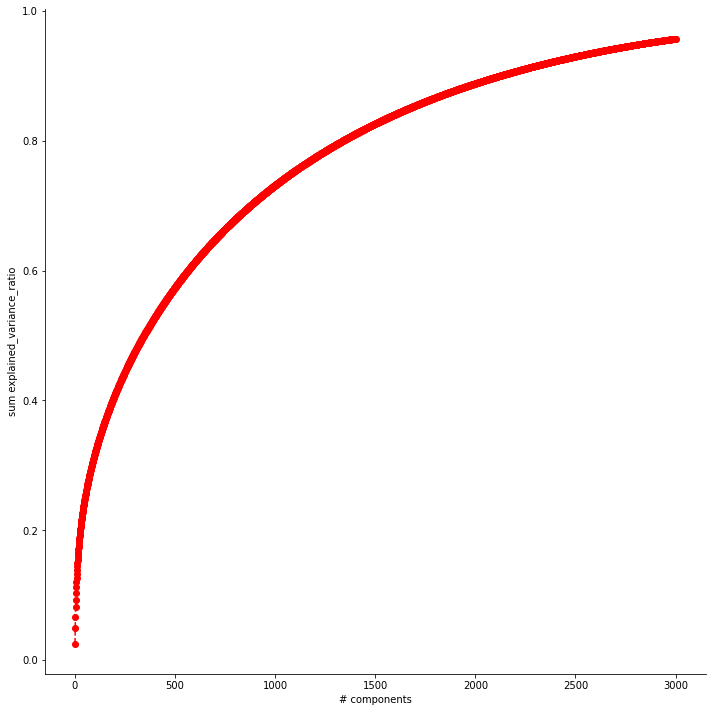

In [22]:
fig = plt.figure(figsize=(10,10))

plt.plot(range(1,len(accumulate_explained_variance_ratio_)+1),accumulate_explained_variance_ratio_,'--ro')

plt.xlabel("# components")
plt.ylabel("sum explained_variance_ratio")

In [23]:
accumulate_explained_variance_ratio_[2000]

0.88826174

In [24]:
print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (4913, 11983)
Test  :  (2105, 11983)


In [25]:
X_train_pca = my_model.transform(X_train)[:,:2000]
X_test_pca  = my_model.transform(X_test)[:,:2000]

In [26]:
print('Train PCA : ',X_train_pca.shape)
print('Test PCA  : ',X_test_pca.shape)

Train PCA :  (4913, 2000)
Test PCA  :  (2105, 2000)


In [27]:
model = LinearRegression(positive=False)
model_name = "LinearRegression"



### crossval_randomly

In [28]:
n= 5
metric_train_rmse_arr, metric_val_rmse_arr, metric_test_RMSE_act,testing_predictions = cross_validate(X_train,y_train, n, X_test, y_test)
print('Total mean metric train RMSE:',np.mean(metric_train_rmse_arr))
print('Total mean metric val   RMSE:',np.mean(metric_val_rmse_arr))
print("Total mean metric test  RMSE:", metric_test_RMSE_act)

******************************
Fold  0
********************
metric_train_RMSE: 3.77811110745155e-05
metric_val_RMSE: 3.9481966721604347
metric_test_RMSE_act: 5.229785992570696
Fold  1
********************
metric_train_RMSE: 2.984414322195634e-05
metric_val_RMSE: 4.831578761865353
metric_test_RMSE_act: 4.808701881420604
Fold  2
********************
metric_train_RMSE: 4.084924941321615e-05
metric_val_RMSE: 2.651350098002304
metric_test_RMSE_act: 5.111364830224462
Fold  3
********************
metric_train_RMSE: 3.937140776680244e-05
metric_val_RMSE: 3.446273219873651
metric_test_RMSE_act: 5.101843727221591
Fold  4
********************
metric_train_RMSE: 3.97032557226917e-05
metric_val_RMSE: 3.6387740546960288
metric_test_RMSE_act: 5.101169787919359
Total mean metric train RMSE: 3.750983343983642e-05
Total mean metric val   RMSE: 3.7032345613195545
Total mean metric test  RMSE: 4.654687173044406
******************************
Total mean metric train RMSE: 3.750983343983642e-05
Total mean m

### PCA + crossval_randomly

In [31]:
n= 5
metric_train_rmse_arr, metric_val_rmse_arr, metric_test_RMSE_act,testing_predictions = cross_validate(X_train_pca,y_train, n, X_test_pca, y_test)
print('Total mean metric train RMSE:',np.mean(metric_train_rmse_arr))
print('Total mean metric val   RMSE:',np.mean(metric_val_rmse_arr))
print("Total mean metric test  RMSE:", metric_test_RMSE_act)

******************************
Fold  0
********************
metric_train_RMSE: 1.7038008478604665
metric_val_RMSE: 3.711442565535749
metric_test_RMSE_act: 4.549097280908901
Fold  1
********************
metric_train_RMSE: 1.4206133344233813
metric_val_RMSE: 4.715778492423385
metric_test_RMSE_act: 4.415101628663283
Fold  2
********************
metric_train_RMSE: 1.788456017368482
metric_val_RMSE: 2.6994883290924943
metric_test_RMSE_act: 4.582117250790045
Fold  3
********************
metric_train_RMSE: 1.7112376246007825
metric_val_RMSE: 3.4165816003806673
metric_test_RMSE_act: 4.609772788388426
Fold  4
********************
metric_train_RMSE: 1.6997410669941049
metric_val_RMSE: 3.5262199048059175
metric_test_RMSE_act: 4.577014235152863
Total mean metric train RMSE: 1.6647697782494433
Total mean metric val   RMSE: 3.613902178447643
Total mean metric test  RMSE: 4.370121658145049
******************************
Total mean metric train RMSE: 1.6647697782494433
Total mean metric val   RMSE: 3.